Alexis Camarasa 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [37]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem
import pylab as plt
from scipy.stats import bernoulli, beta 

In [13]:
# datos
df = pd.read_csv('C:/Users/alexi/IronHack/6.4-lab_ab_testing/data/cookie_cats.csv')
df.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
6,1066,gate_30,0,False,False
7,1444,gate_40,2,False,False
8,1574,gate_40,108,True,True
9,1587,gate_40,153,True,False


In [34]:
# transformacion
""" H0: Gate 30  H1 Gate 40"""


' H0: Gate 30  H1 Gate 40'

In [17]:
# muestreo
pd.crosstab(df.version, df.retention_1)

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


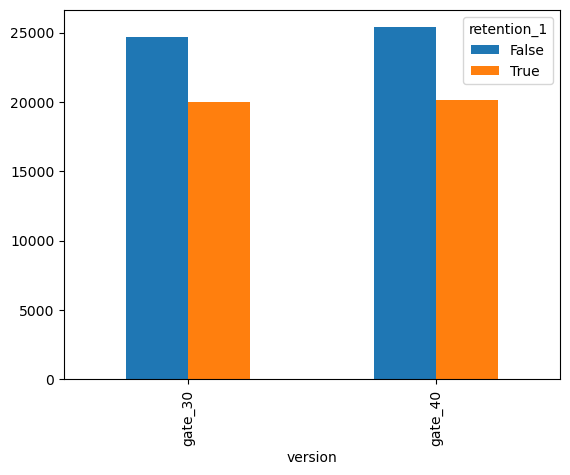

In [18]:
pd.crosstab(df.version, df.retention_1).plot(kind='bar');

In [19]:
pd.crosstab(df.version, df.retention_7)

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


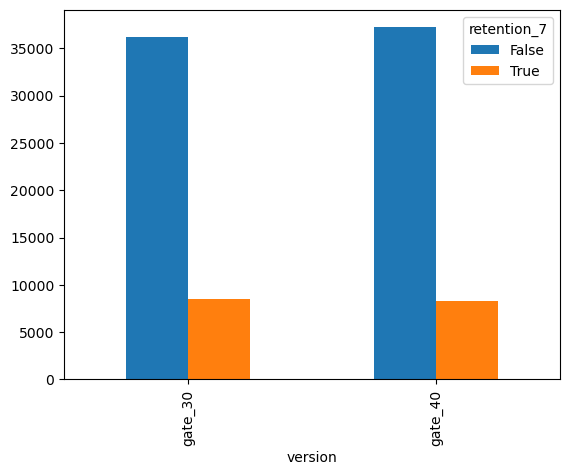

In [20]:
pd.crosstab(df.version, df.retention_7).plot(kind='bar');

In [25]:
# testeo para retention_1
control = df[df.version=='gate_30']

tratamiento = df[df.version=='gate_40']

ab_test=pd.concat([control, tratamiento], axis=0)

ab_test.reset_index(drop=True, inplace=True)

ab_test.head()


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,1066,gate_30,0,False,False
3,2101,gate_30,0,False,False
4,2179,gate_30,39,True,False


In [24]:
ab_test.tail()

,userid,version,sum_gamerounds,retention_1,retention_7
90184,9998733,gate_40,10,True,False
90185,9999441,gate_40,97,True,False
90186,9999479,gate_40,30,False,False
90187,9999768,gate_40,51,True,False
90188,9999861,gate_40,16,False,False


In [23]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [28]:
ab_test.version.value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

In [35]:
# testeo para retention_1

imps_ctrl, convs_ctrl = 44700, 20034    # retenciones

imps_test, convs_test = 45489, 20119 


CR_ctrl = convs_ctrl/imps_ctrl
CR_test = convs_test/imps_test

f'Tasas conversion: Control: {CR_ctrl}, Test: {CR_test}'

'Tasas conversion: Control: 0.4481879194630872, Test: 0.44228274967574577'

In [38]:
a_C, b_C = 1+convs_ctrl, 1+imps_ctrl-convs_ctrl

a_T, b_T = 1+convs_test, 1+imps_test-convs_test

beta_control = beta(a_C, b_C)

beta_test = beta(a_T, b_T)

In [39]:
beta_control.mean(), beta_test.mean()

(0.44819023757326293, 0.44228528719966587)

In [52]:
from scipy.stats import beta
import numpy as np
from math import lgamma
import matplotlib.pyplot as plt


def f(a, b, c, d):
    num = lgamma(a + c) + lgamma(b + d) + lgamma(a + b) + lgamma(c + d)
    den = lgamma(a) + lgamma(b) + lgamma(c) + lgamma(d) + lgamma(a + b + c + d)
    return np.exp(num - den)


def f_iter(a, b, c, d):
    while d > 1:
        d -= 1
        yield f(a, b, c, d) / d
        
        
def g0(a, b, c):    
    return np.exp(lgamma(a + b) + lgamma(a + c) - (lgamma(a + b + c) + lgamma(a)))

def g(a, b, c, d):
    return g0(a, b, c) + sum(f_iter(a, b, c, d))



def calc_prob(beta1, beta2):
    return g(beta1.args[0], beta1.args[1], beta2.args[0], beta2.args[1])
    
    

def pico(a, b):
    return (a-1)/(a+b-2)



def plot(betas, names, linf=0.42, lsup=0.47):
    x=np.linspace(linf, lsup, 100)
    for f, n in zip(betas, names):
        y=f.pdf(x)
        y_pico=pico(f.args[0], f.args[1])
        y_var=f.var()
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(n, y_pico, y_var))
        plt.yticks([])
    plt.legend()
    plt.show();

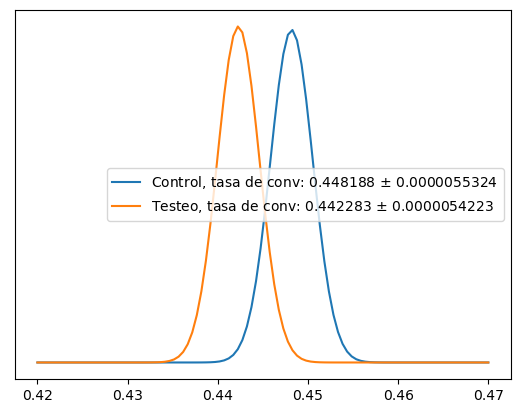

In [53]:
plot([beta_control, beta_test], ['Control', 'Testeo'])

In [54]:
# testeo para retention_7
imps_ctrl, convs_ctrl = 44700, 8502    # retenciones

imps_test, convs_test = 45489, 8279 


CR_ctrl = convs_ctrl/imps_ctrl
CR_test = convs_test/imps_test

f'Tasas conversion: Control: {CR_ctrl}, Test: {CR_test}'

'Tasas conversion: Control: 0.19020134228187918, Test: 0.18200004396667327'

In [55]:
a_C, b_C = 1+convs_ctrl, 1+imps_ctrl-convs_ctrl

a_T, b_T = 1+convs_test, 1+imps_test-convs_test

beta_control = beta(a_C, b_C)

beta_test = beta(a_T, b_T)

In [56]:
beta_control.mean(), beta_test.mean()

(0.19021520289919913, 0.18201402475214878)

In [58]:
from scipy.stats import beta
import numpy as np
from math import lgamma
import matplotlib.pyplot as plt


def f(a, b, c, d):
    num = lgamma(a + c) + lgamma(b + d) + lgamma(a + b) + lgamma(c + d)
    den = lgamma(a) + lgamma(b) + lgamma(c) + lgamma(d) + lgamma(a + b + c + d)
    return np.exp(num - den)


def f_iter(a, b, c, d):
    while d > 1:
        d -= 1
        yield f(a, b, c, d) / d
        
        
def g0(a, b, c):    
    return np.exp(lgamma(a + b) + lgamma(a + c) - (lgamma(a + b + c) + lgamma(a)))

def g(a, b, c, d):
    return g0(a, b, c) + sum(f_iter(a, b, c, d))



def calc_prob(beta1, beta2):
    return g(beta1.args[0], beta1.args[1], beta2.args[0], beta2.args[1])
    
    

def pico(a, b):
    return (a-1)/(a+b-2)



def plot(betas, names, linf=0.17, lsup=0.20):
    x=np.linspace(linf, lsup, 100)
    for f, n in zip(betas, names):
        y=f.pdf(x)
        y_pico=pico(f.args[0], f.args[1])
        y_var=f.var()
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(n, y_pico, y_var))
        plt.yticks([])
    plt.legend()
    plt.show();

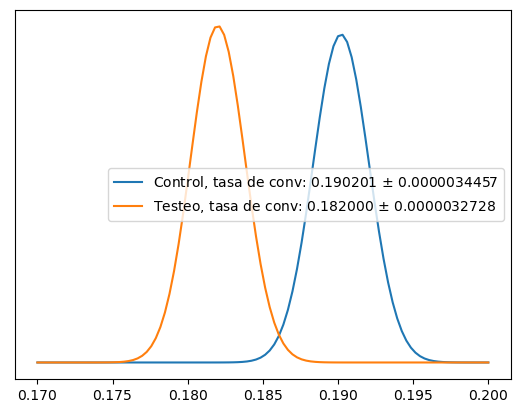

In [59]:
plot([beta_control, beta_test], ['Control', 'Testeo'])

In [62]:
# conclusiones
# Explica detalladamente las conclusiones obtenidas de. tu testeo.
""" No merece la pena cambiar a la version testo ya que es ligeramente inferior a la version control. Podemos ver que la version testeo retencion 1 es casi igual a la version control pero en la version testeo retencion 7 se evidencia aun mas la hipotesis de conservar la version control por sobre la version testo"""


' No merece la pena cambiar a la version testo ya que es ligeramente inferior a la version control. Podemos ver que la version testeo retencion 1 es casi igual a la version control pero en la version testeo retencion 7 se evidencia aun mas la hipotesis de conservar la version control por sobre la version testo'